In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

X_train = pd.read_pickle('./data/X_train_pickle.pkl')
X_test = pd.read_pickle('./data/X_test_pickle.pkl')
y_train = pd.read_pickle('./data/y_train_pickle.pkl')
y_test = pd.read_pickle('./data/y_test_pickle.pkl')

In [2]:
# adjust the variables to your liking.
neighbors = list(range(1,13))
cv=5

In [3]:
# Run this cell once to save results to your disk.
# Will take about 3 minutes to run. 
knn = KNeighborsClassifier()
param_grid = [{'n_neighbors':neighbors}]
knn_grid_search = GridSearchCV(knn, param_grid, cv=cv,    # Just passing in the variables declared above.
                               scoring='f1',
                               n_jobs=-2,                               # Uses all but one of machine's processors.
                               verbose=50)                              # verbose > 0 gives us a progress bar to check on.
knn_grid_search.fit(X_train, y_train)
%store knn_grid_search
knn_grid_search.best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   1 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-2)]: Done   2 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-2)]: Done   3 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-2)]: Done   5 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-2)]: Done   6 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-2)]: Done   7 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-2)]: Done   8 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-2)]: Done   9 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-2)]: Done  10 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:   36.2s
[Parallel(n_jobs=-2)]: Done  12 tasks      | elapsed:   36.4s
[Parallel(n_jobs=-2)]: Done  13 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-2)]: Done  14 tasks      | elapsed:   3

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=11, p=2,
                     weights='uniform')

# End of GridSearch -> Calculate Results

In [4]:
%store -r knn_grid_search
y_pred = knn_grid_search.predict(X_test)
knn_acc = round(accuracy_score(y_test, y_pred)*100, 3)
knn_f1 = round(knn_grid_search.best_score_*100, 3)
print("Knn accuracy:{} and KNN F1:{}".format(knn_acc, knn_f1))

knn = {
    'accuracy': knn_acc,
    'f1': knn_f1
}
%store knn

Knn accuracy:82.397 and KNN F1:61.958
Stored 'knn' (dict)


## Plot Confusion Matrix

>https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

In [5]:
# from sklearn.metrics, we use confusion_matrix and pass in the y_test and y hat; saving the result as cm.
# this will calculate how many true positives, true negatives, false positives, and false negatives there are.
cm = confusion_matrix(y_test,y_pred)

# because we're aiming to predict a value over/under 50K, we set the classes appropriately. 
classes = ['<=50K', '>50K']

In [6]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
#         if normalized, convert the confusion matrix to a float, then divide the top quadrants by the summation of the top row
#           and bottom quadrants by the summation of the bottom row to get a percentage for each quadrant.
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

#     Set the plt with the confusion matrix, the colors defined (in this case default)
    plt.imshow(cm, interpolation='nearest', cmap=cmap) # <- What is interpolation?
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes)) 
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

# what is all of this?
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion Matrix, without normalization
[[4102  425]
 [ 631  841]]


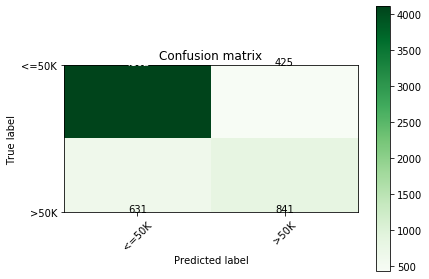

In [7]:
plot_confusion_matrix(cm, classes=classes)

Normalized confusion matrix
[[0.90611884 0.09388116]
 [0.42866848 0.57133152]]


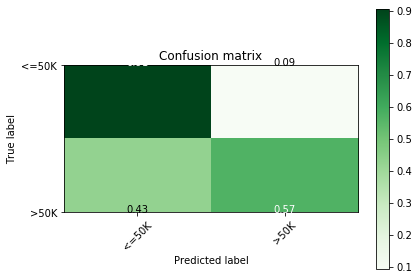

In [8]:
plot_confusion_matrix(cm, classes=classes, normalize=True)

The number of Positives that were correctly identified are 57% of the actual Positives that exist in the dataset. This is also known as Recall.

We want to use Recall as a way to compare the effectiveness of different algorithms because we would rather falsely predict a lower salary of an individual(False Negatives), so that they could adequately prepare themselves financially. We would not want to falsely predict higher salaries for individuals, so that they will not have to deal with financial complications(False Positives).